# MedMnist - Breast Dataset

#### Import required modules

In [ ]:
import numpy as np
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, RandomFlip, RandomRotation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.python.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from tensorflow.python.ops.gen_dataset_ops import dataset_to_graph_eager_fallback
import pandas as pd
import seaborn as sns
from keras.utils.vis_utils import plot_model


## Define Functions for the use case 

#### Load Dataset

In [ ]:
def load_dataset(npz_file_path):
  data = np.load(npz_file_path)
  # train_dataset = np.column_stack((data['train_images'], data['train_labels']))
  # test_dataset = np.column_stack((data['test_images'], data['test_labels']))
  train_X = data['train_images']
  train_Y = data['train_labels']
  test_X = data['test_images']
  test_Y = data['test_labels']
  val_X = data['val_images']
  val_Y = data['val_labels']
  
  train_X = train_X/255.0
  test_X = test_X/255.0
  val_X = val_X/255.0

  return train_X, train_Y, test_X, test_Y, val_X, val_Y


#### Check data imbalance status in train data

In [ ]:
def check_train_class_balance(train_Y) -> (bool, dict):

  unique, counts = np.unique(train_Y, return_counts=True)
  label_dict = dict(zip(unique, counts))
  isTrue =  True if label_dict[0] == label_dict[1] else False
  
  df = pd.DataFrame.from_dict([label_dict])
  ax = sns.barplot(data = df)
  ax.set(xlabel='Breast Sample Results(1: Malignant negative, 0: Malignant Positive)', ylabel='No of Samples')
  plt.show()
  return isTrue, label_dict


#### Show 15 random images from dataset with ground truth

In [ ]:
def plot_ground_truth_images(train_X, train_Y):
  # Convert the output labels to one-hot encoded format#
  y_breast = to_categorical(train_Y)

  # Create a dictionary mapping class indices to class labels
  class_labels_breast = {0: 'Malignant',1: 'Normal'}

  # Randomly select 15 images from the dataset
  indices_breast = np.random.choice(train_X.shape[0], size=15, replace=False)

  # Plot the images and corresponding class labels
  fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
  for i, ax in enumerate(axes.flat):
    ax.imshow(train_X[indices_breast[i]], cmap='gray')
    ax.set_title(class_labels_breast[np.argmax(y_breast[indices_breast[i]])])
    ax.axis('off')
  plt.tight_layout()
  plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import cv2 as cv2
# from PIL import Image
# indx = 10
# plt.imshow(test_X[indx], cmap='gray')

# plt.axis('off')
# # plt.imsave('test_18.jpg',test_X[indx], cmap='gray')
# # plt.show()
# im = Image.fromarray(np.uint8(test_X[indx]))
# cv2.imwrite('test_10.png', test_X[indx])

Support class balance with RandomOversampler

In [ ]:
def oversample_train_data_class(train_X,train_Y)-> (bool, np.ndarray, np.ndarray, dict):
  # Preprocess train X data for oversampling, i.e. flattening shape from (546,28,28) to (546,784)
  X = train_X.reshape(len(train_X),-1)

  # Use RandomOverSampler from imblearn for oversampling minority class, i.e. 0 (Malignant) in this case
  ros = RandomOverSampler(random_state=0)
  X_resampled, y_resampled = ros.fit_resample(X, train_Y)

  # Reshape train data back to (798,28,28)
  X_resampled=X_resampled.reshape(798,28,28)
  X_resampled = np.expand_dims(X_resampled, axis=-1)
  unique, counts = np.unique(y_resampled, return_counts=True)
  label_dict = dict(zip(unique, counts))

  # Evaluate the oversampled data and check for imbalance again
  isTrue =  True if label_dict[0] == label_dict[1] else False
  return isTrue, X_resampled, y_resampled, label_dict

Support augmentation for given datasest with batch_size=32

In [ ]:
def augment_train_data(train_X, train_Y, batch_size=32):
  datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
  )

  datagen.fit(train_X)
  augmented_data = datagen.flow(train_X, train_Y, batch_size=batch_size)
  return augmented_data

Create model skeleton

In [ ]:

def create_model_backbone()->keras.Model:
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(3,3), padding='valid', activation='relu', input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='valid'))

  model.add(Conv2D(32,kernel_size=(3,3), padding='valid', activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32,kernel_size=(3,3), padding='valid', activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))

  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(128,kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.5)))
  return model

Self defined functions for demonstrating - Recall, Precision, and F1 score

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#### Compile Model

In [ ]:
def compile_model(model: keras.Model, lr=0.0001) -> keras.Model:
  # Create Adam optimizer with learning rate set to 0.0001
  optimizer = keras.optimizers.RMSprop(learning_rate=lr)

  # Create Binary Cross entropy for loss function
  loss = tf.keras.losses.BinaryCrossentropy()

  # Compile and return model
  model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
  return model

## Train Model with augmentation on

In [ ]:
# Train Model with Augmentation
def train_model_with_aug(train_data, model: keras.Model, validation_X:np.ndarray,validation_Y:np.ndarray, callbacks = [], epochs=80, verbose=1, steps_per_epoch=17, batch_size=32):
  
  resampled_val_X = np.expand_dims(val_X, axis=-1)
  # Fit model for training
  history = model.fit(train_data, validation_data=(val_X, val_Y), epochs=epochs, verbose=verbose, steps_per_epoch=steps_per_epoch, callbacks=callbacks, batch_size=batch_size)
  return history

# Train Model without Augmentation
def train_model_without_aug(train_data, model: keras.Model, validation_X:np.ndarray,validation_Y:np.ndarray, callbacks = [], epochs=80, verbose=1, steps_per_epoch=17, batch_size=32):
  
  resampled_val_X = np.expand_dims(val_X, axis=-1)
  # Fit model for training
  history = model.fit(train_data[0], train_data[1], validation_data=(val_X, val_Y), epochs=epochs, verbose=verbose, steps_per_epoch=steps_per_epoch, callbacks=callbacks, batch_size=batch_size)
  return history

#### Generate evaluation metrics with Truth and Prediction


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

def generate_eval_metrics_v2(model, test_X, test_Y, pretrained=False):
  # Function for eEvaluation Metrics
  if pretrained == False:
    test_X = test_X.reshape(-1,28,28,1)
  else:
    test_X = test_X_rgb.reshape(-1,75,75,3)


  y_pred_prob= model.predict(test_X,verbose=0)
  y_pred=np.rint(y_pred_prob)
  y_true=test_Y

  ## accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_true, y_pred)
  print('Accuracy: %.2f ' % (accuracy*100))

  ## precision tp / (tp + fp)
  precision = precision_score(y_true, y_pred,average='weighted')
  print('Precision: %.2f ' % (precision*100))

  ## recall: tp / (tp + fn)
  recall = recall_score(y_true, y_pred,average='weighted')
  print('Recall: %.2f ' % (recall*100))

  
  ## f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_true, y_pred,average='weighted')
  print('F1 score: %.2f ' % (f1*100))

  ## ROC AUC
  auc = roc_auc_score(y_true, y_pred_prob)
  print('ROC AUC: %.2f' % auc)

#### Plot Accuracy and Loss graph

In [ ]:
def plot_model_accuracy_graph(history):
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  epoch_count = range(1, len(training_loss) + 1)

  plt.plot(epoch_count, training_loss, "r--")
  plt.plot(epoch_count, test_loss, "b--")
  plt.legend(["Training Loss", "Test Loss"])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  # plt.yticks([0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00])
  plt.show()


  training_accuracy = history.history["accuracy"]
  test_accuracy = history.history["val_accuracy"]

  plt.plot(epoch_count, training_accuracy, "r--")
  plt.plot(epoch_count, test_accuracy, "b--")
  plt.legend(["Training Accuracy", "Test Accuracy"])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy Score")
  plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
  plt.show()

#### Prediction function

In [ ]:
def predict_class_of_image(model: keras.Model, indx: int):
  test = test_X[indx].reshape(-1,28,28,1)
  prediction = model.predict(test)
  if prediction[0] > 0.58:
    predicted_label = 'Malignant'
  else:
    predicted_label = 'Normal'

  # Display the image and the actual/predicted labels
  plt.imshow(test.reshape(28, 28), cmap='gray')
  plt.title(f"Actual Label: {test_Y[ind]}\nPredicted Label: {predicted_label}")
  plt.axis('off')
  plt.show()

In [ ]:
# Train, Val, Test - loading of data
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

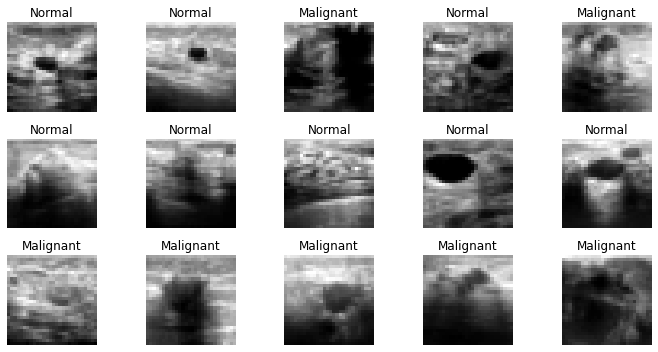

In [ ]:
# Plot Ground Truth and coresponding images of train data
plot_ground_truth_images(train_X, train_Y)

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# model = create_model_backbone()
# model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# # Use scikit-learn to grid search the batch size, optimizers and epochs
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
# # Function to create model, required for KerasClassifier
# # fix random seed for reproducibility
# seed = 7
# tf.random.set_seed(seed)

# # create model
# model = KerasClassifier(model=compile_model(model, lr=0.0001), verbose=0)
# # define the grid search parameters
# batch_size = [32,64.96]
# optimizers = ['rmsprops','adam','sgd']
# epochs = [80,90,100,120]
# # initializers = ['glorot_uniform', 'norma', 'uniform']
# param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)
# grid_result = grid.fit(train_X, train_Y, verbose=1)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

#### Model with No Augmentation and no Oversampling (training with imbalanced dataset)

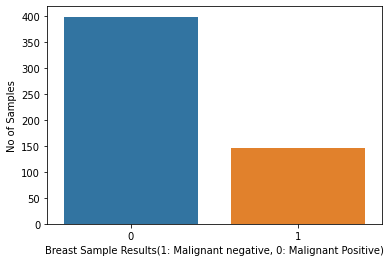

Is train data classes balanced : False
{0: 399, 1: 147}


In [ ]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

# Check for balanced classes in train data
train_Y=np.bitwise_xor(train_Y, 1) 
val_Y=np.bitwise_xor(val_Y, 1)
test_Y=np.bitwise_xor(test_Y, 1) 
isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

In [ ]:

# # Print final value of evaluation
# isBalanced, train_X, train_Y, nunique_classes = oversample_train_data_class(train_X, train_Y)
# _ = check_train_class_balance(train_Y)
# print("Is train data classes balanced : %s" % isBalanced)
# print(nunique_classes)

batch_size = 32

model_1 = create_model_backbone()
model_1.summary()

train_X = np.expand_dims(train_X, axis=-1)

train_data_1 = (train_X,train_Y)
compiled_model_1 = compile_model(model_1, lr=0.0001)
history_1 = train_model_without_aug(train_data_1, model_1, val_X, val_Y, epochs=120, steps_per_epoch=np.rint(len(train_X)//batch_size), batch_size=batch_size)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 26, 26, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                      

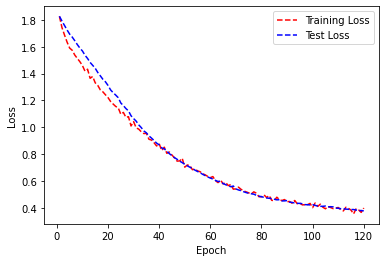

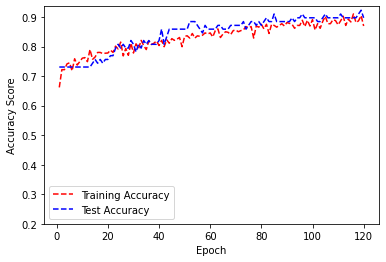

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


NameError: ignored

In [ ]:
plot_model_accuracy_graph(history_1)
print(history_1.history.keys())

generate_eval_metrics_v2(model_1, test_X, test_Y)

#### Model with Augmentation alone

In [ ]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

# Check for balanced classes in train data
train_Y=np.bitwise_xor(train_Y, 1) 
val_Y=np.bitwise_xor(val_Y, 1)
test_Y=np.bitwise_xor(test_Y, 1) 
isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

NameError: ignored

In [ ]:
# # Print final value of evaluation
# isBalanced, train_X, train_Y, nunique_classes = oversample_train_data_class(train_X, train_Y)
# _ = check_train_class_balance(train_Y)
# print("Is train data classes balanced : %s" % isBalanced)
# print(nunique_classes)

batch_size = 32

model_2 = create_model_backbone()
model_2.summary()

train_X = np.expand_dims(train_X, axis=-1)

train_data_2 = augment_train_data(train_X,train_Y, batch_size=32)
compiled_model_2 = compile_model(model_2, lr=0.0001)
history_2 = train_model_with_aug(train_data_2, model_2, val_X, val_Y, epochs=100, steps_per_epoch=np.rint(len(train_X)//batch_size), batch_size=batch_size)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_197 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_50 (Bat  (None, 26, 26, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_196 (MaxPooli  (None, 13, 13, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_198 (Conv2D)         (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_197 (MaxPooli  (None, 5, 5, 32)         0         
 ng2D)                                                           
                                                     

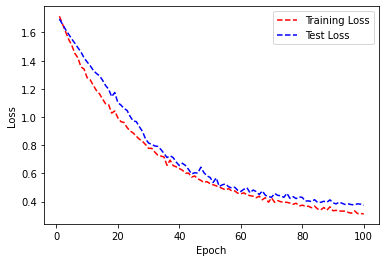

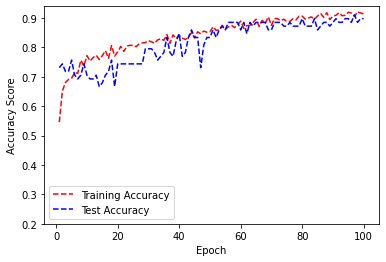

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Accuracy: 80.77 
Precision: 79.91 
Recall: 80.77 
F1 score: 80.08 
ROC AUC: 0.83


In [ ]:
plot_model_accuracy_graph(history_2)
print(history_2.history.keys())

generate_eval_metrics_v2(model_2, test_X, test_Y)

#### Model Random OverSampler - no Augmentation

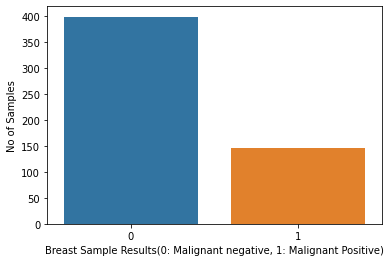

Is train data classes balanced : False
{0: 399, 1: 147}


In [ ]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

# Check for balanced classes in train data
train_Y=np.bitwise_xor(train_Y, 1) 
val_Y=np.bitwise_xor(val_Y, 1)
test_Y=np.bitwise_xor(test_Y, 1) 
isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

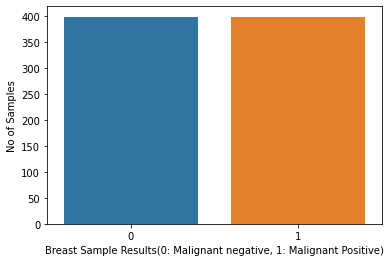

Is train data classes balanced : True
{0: 399, 1: 399}
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_42 (Bat  (None, 26, 26, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_164 (MaxPooli  (None, 13, 13, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_166 (Conv2D)         (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 5, 5, 32)         0         
 ng2D)                                                          

In [ ]:
# Print final value of evaluation
isBalanced, train_X, train_Y, nunique_classes = oversample_train_data_class(train_X, train_Y)
_ = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

batch_size = 32

model_3 = create_model_backbone()
model_3.summary()


train_data_3 = (train_X,train_Y)
compiled_model_3 = compile_model(model_3, lr=0.0001)
history_3 = train_model_without_aug(train_data_3, model_3, val_X, val_Y, epochs=100, steps_per_epoch=np.rint(len(train_X)//batch_size), batch_size=batch_size)

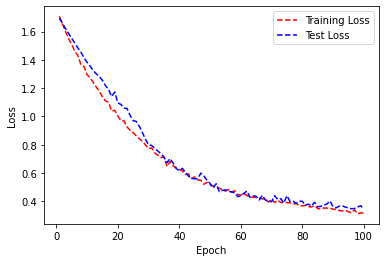

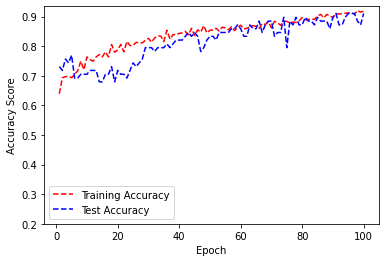

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
plot_model_accuracy_graph(history_3)
print(history_3.history.keys())

generate_eval_metrics_v2(model_3, test_X, test_Y)

#### Model with Augmentation and Random OverSampler

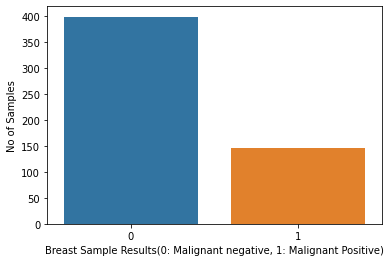

Is train data classes balanced : False
{0: 399, 1: 147}


In [ ]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

# Check for balanced classes in train data
train_Y=np.bitwise_xor(train_Y, 1) 
val_Y=np.bitwise_xor(val_Y, 1)
test_Y=np.bitwise_xor(test_Y, 1) 
isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

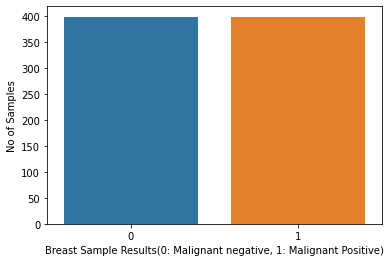

Is train data classes balanced : True
{0: 399, 1: 399}
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_37 (Bat  (None, 26, 26, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 13, 13, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 5, 5, 32)         0         
 ng2D)                                                          

In [ ]:
# Print final value of evaluation
isBalanced, train_X, train_Y, nunique_classes = oversample_train_data_class(train_X, train_Y)
_ = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

batch_size = 32

model_4 = create_model_backbone()
model_4.summary()

# Create self defined model for deep learning
model_4 = create_model_backbone()
model_4.summary()

# Augment Data and us it for training the model
train_data_4 = augment_train_data(train_X,train_Y, batch_size=32)
compiled_model_4 = compile_model(model_4, lr=0.0001)
history_4 = train_model_with_aug(train_data_4, model_4, val_X, val_Y, epochs=100, steps_per_epoch=17)

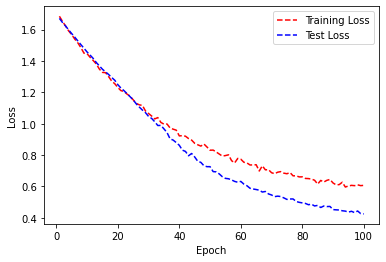

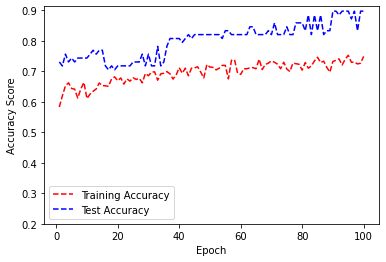

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
plot_model_accuracy_graph(history_4)
print(history.history.keys())

generate_eval_metrics_v2(model_4, test_X, test_Y)

In [ ]:
model.save("/saved_models/")

In [ ]:
ind = 20
predict_class_of_image(model, ind)

1/1 [==============================] - 0s 130ms/step
[[0.8493128]]
[1]


#### Save trained model to file

In [ ]:
!mkdir -p saved_model
model.save('saved_model/breast_self_model')

In [ ]:
!zip -r /content/saved_model /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/breast_self_model/ (stored 0%)
  adding: content/saved_model/breast_self_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/breast_self_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/breast_self_model/assets/ (stored 0%)
  adding: content/saved_model/breast_self_model/variables/ (stored 0%)
  adding: content/saved_model/breast_self_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/saved_model/breast_self_model/variables/variables.index (deflated 62%)
  adding: content/saved_model/breast_self_model/keras_metadata.pb (deflated 92%)


In [ ]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Pre Trained Model

In [ ]:
def predict_class_of_image_v2(model: keras.Model, indx: int, test_X):
  test = test_X[indx].reshape(1,75,75,3)
  print(test.shape)
  prediction = model.predict(test)
  print(prediction)
  if prediction[0] > 0.40:
    predicted_label = 'Malignant'
  else:
    predicted_label = 'Normal'

  # Display the image and the actual/predicted labes
  plt.imshow(test.reshape(75, 75,3), cmap='gray')
  plt.title(f"Actual Label: {'Normal' if test_Y[indx] == 0 else 'Malignant'}\nPredicted Label: {predicted_label}")
  plt.axis('off')
  plt.show()

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                              include_top=False,  
                              input_shape=(75, 75, 3))
for layer in base_model.layers[:50]: # freeze first 50 layers 
    layer.trainable = False
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer for binary classification
predictions = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.5))(x)
model_final = Model(base_model.input, predictions)
model_final.summary()
plot_model(model_final, to_file='pretrain_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_474 (Conv2D)            (None, 37, 37, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_471 (Batch  (None, 37, 37, 32)  96          ['conv2d_474[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_470 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_471[0

In [ ]:
model_final.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

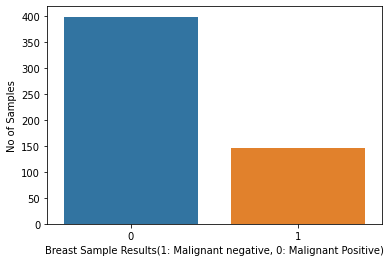

Is train data classes balanced : False
{0: 399, 1: 147}


In [ ]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

# Check for balanced classes in train data
train_Y=np.bitwise_xor(train_Y, 1) 
val_Y=np.bitwise_xor(val_Y, 1)
test_Y=np.bitwise_xor(test_Y, 1) 
isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

In [ ]:
import cv2
train_Images = []
for image in train_X:
    resized = cv2.resize(image, (75,75), interpolation = cv2.INTER_AREA)
    train_Images.append(resized)

train_Images = np.array(train_Images)
train_Images.shape


val_Images = []
for image in val_X:
    resized = cv2.resize(image, (75,75), interpolation = cv2.INTER_AREA)
    val_Images.append(resized)

val_Images = np.array(val_Images)

test_Images = []
for image in test_X:
    resized = cv2.resize(image, (75,75), interpolation = cv2.INTER_AREA)
    test_Images.append(resized)

test_Images = np.array(test_Images)


train_X_rgb = np.repeat(train_Images[..., np.newaxis], 3, -1)
val_X_rgb = np.repeat(val_Images[..., np.newaxis], 3, -1)
test_X_rgb = np.repeat(test_Images[..., np.newaxis], 3, -1)
STEPS = len(train_X) / 32
test_X_rgb.shape

(156, 75, 75, 3)

In [ ]:
history = model_final.fit(train_X_rgb, train_Y, steps_per_epoch=STEPS, batch_size = 32, epochs=30, validation_data=(val_X_rgb, val_Y))

Epoch 1/30
17/17 [==============================] - 60s 2s/step - loss: 1.5743 - accuracy: 0.6850 - val_loss: 1.4952 - val_accuracy: 0.7179
Epoch 2/30
17/17 [==============================] - 35s 2s/step - loss: 1.4423 - accuracy: 0.7363 - val_loss: 1.7419 - val_accuracy: 0.7308
Epoch 3/30
17/17 [==============================] - 36s 2s/step - loss: 1.3146 - accuracy: 0.7509 - val_loss: 1.6965 - val_accuracy: 0.7308
Epoch 4/30
17/17 [==============================] - 35s 2s/step - loss: 1.1960 - accuracy: 0.8571 - val_loss: 1.3296 - val_accuracy: 0.7821
Epoch 5/30
17/17 [==============================] - 33s 2s/step - loss: 1.0580 - accuracy: 0.9341 - val_loss: 1.2815 - val_accuracy: 0.7949
Epoch 6/30
17/17 [==============================] - 35s 2s/step - loss: 0.9550 - accuracy: 0.9487 - val_loss: 1.2084 - val_accuracy: 0.8205
Epoch 7/30
17/17 [==============================] - 35s 2s/step - loss: 0.8741 - accuracy: 0.9707 - val_loss: 1.1574 - val_accuracy: 0.7692
Epoch 8/30
17/17 [==

(1, 75, 75, 3)
1/1 [==============================] - 0s 52ms/step
[[0.30923387]]


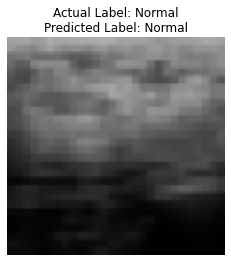

(1, 75, 75, 3)
1/1 [==============================] - 0s 115ms/step
[[0.2926808]]


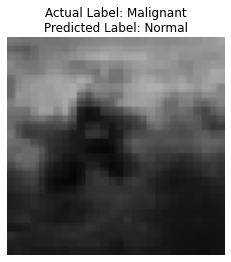

(1, 75, 75, 3)
1/1 [==============================] - 0s 101ms/step
[[0.2536634]]


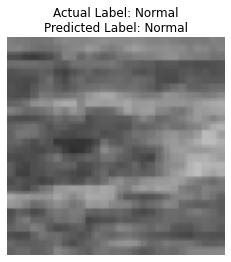

(1, 75, 75, 3)
1/1 [==============================] - 0s 105ms/step
[[0.43622562]]


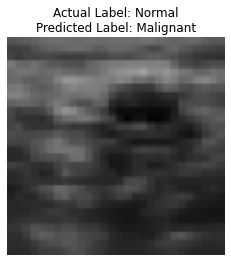

In [ ]:
predict_class_of_image_v2(model_final,30, test_X_rgb)
predict_class_of_image_v2(model_final,45, test_X_rgb)
predict_class_of_image_v2(model_final,50, test_X_rgb)
predict_class_of_image_v2(model_final,75, test_X_rgb)

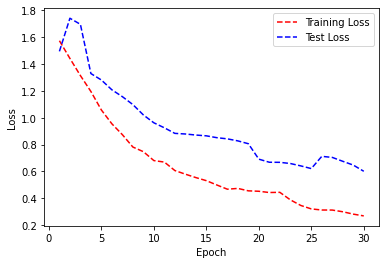

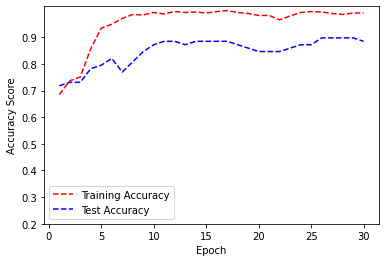

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Accuracy: 83.97 
Precision: 83.37 
Recall: 83.97 
F1 score: 83.32 
ROC AUC: 0.84


In [ ]:
plot_model_accuracy_graph(history)
print(history.history.keys())

generate_eval_metrics_v2(model_final, test_X_rgb, test_Y, pretrained=True)

# Reference
Boesch, G. (2023) Deep Residual Networks (ResNet, ResNet50) – 2023 Guide. [Online] 
Available at: https://viso.ai/deep-learning/resnet-residual-neural-network/#:~:text=Deep%20residual%20networks%20like%20the,other%20to%20form%20a%20network.
[Accessed 10 February 2023].

Brital, A. (2021) Inception V3 CNN Architecture Explained. [Online] 
Available at: https://medium.com/@AnasBrital98/inception-v3-cnn-architecture-explained-691cfb7bba08
[Accessed 10 March 2023].

Brownlee, J. (2016) Use Keras Deep Learning Models with Scikit-Learn in Python. [Online] 
Available at: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
[Accessed 8 March 2023].

Brownlee, J. (2022) How to Calculate Precision, Recall, F1, and More for Deep Learning Models. [Online] 
Available at: https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
[Accessed 3 March 2023].

Foo, F. (2014) How to normalize a confusion matrix?. [Online] 
Available at: https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
[Accessed 15 March 2023].

Google (N/A) imagenet/inception_v1/classification. [Online] 
Available at: https://tfhub.dev/google/imagenet/inception_v1/classification/5
[Accessed 12 March 2023].

Google (N/A) imagenet/resnet_v1_50/classification. [Online] 
Available at: https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5
[Accessed 10 March 2023].

Hoorn, R. v. (2022) Ways to Reduce False Positive or False Negatives in Binary Classification (0,1). [Online] 
Available at: https://ai.stackexchange.com/questions/38405/ways-to-reduce-false-positive-or-false-negatives-in-binary-classification-0-1
[Accessed 10 March 2023].

Hugging Face (N/A) google/efficientnet-b3. [Online] 
Available at: https://huggingface.co/google/efficientnet-b3
[Accessed 10 March 2023].

Imbalance-learn (N/A) imblearn.over_sampling.RandomOverSampler. [Online] 
Available at: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html
[Accessed 25 February 2023].

Ji, Q., Huang, J., He, W. & Sun, Y. (2019) Optimized Deep Convolutional Neural Networks for Identification of Macular Diseases from Optical Coherence Tomography Images. [Online] 
Available at: https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images
[Accessed 16 March 2023].

Keras (N/A) Adam. [Online] 
Available at: https://keras.io/api/optimizers/adam/
[Accessed 26 February 2023].

Keras (N/A) https://keras.io/api/applications/xception/. [Online] 
Available at: https://keras.io/api/applications/xception/
[Accessed 27 February 2023].

Keras (N/A) Layer weight regularizers. [Online] 
Available at: https://keras.io/api/layers/regularizers/
[Accessed 27 February 2023].

Koech, K. E. (2020) Cross-Entropy Loss Function. [Online] 
Available at: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e#:~:text=Categorical%20cross%2Dentropy%20is%20used,%5D%20for%203%2Dclass%20problem
[Accessed 25 February 2023].

Korstanje, J. (2021) The F1 score. [Online] 
Available at: https://towardsdatascience.com/the-f1-score-bec2bbc38aa6
[Accessed 15 March 2023].

Kumar, V. & jeffhale (2018) Inverse Process of Label Binarisation in Python. [Online] 
Available at: https://stackoverflow.com/questions/45118093/inverse-process-of-label-binarisation-in-python
[Accessed 15 March 2023].

Liang, X. (N/A) Machine Learning and Artificial Intelligence. [Online] 
Available at: https://kingston.app.box.com/s/9us9iwuz2nqm1fpgyf8oyy06zo81y263
[Accessed 5 February 2023].

machine-learning (2022) Inception-V1 (GoogLeNet): Summary and Implementation. [Online] 
Available at: https://hackmd.io/@machine-learning/Bk-61Fo8U
[Accessed 14 March 2023].

Narkhede, S. (2018) Understanding AUC - ROC Curve. [Online] 
Available at: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
[Accessed 15 March 2023].

NumPy (N/A) Array creation routines. [Online] 
Available at: https://numpy.org/doc/stable/reference/routines.array-creation.html
[Accessed 10 March 2023].

Rana, A. (2019) Scikit-learn's LabelBinarizer vs. OneHotEncoder. [Online] 
Available at: https://stackoverflow.com/questions/50473381/scikit-learns-labelbinarizer-vs-onehotencoder#:~:text=Scikitlearn%20suggests%20using%20OneHotEncoder%20for%20X%20matrix%20i.e.,you%20won%27t%20really%20need%20that%20in%20y%20labels
[Accessed 10 March 2023].

Sachan, A. (N/A) Detailed Guide to Understand and Implement ResNets. [Online] 
Available at: https://cv-tricks.com/keras/understand-implement-resnets/
[Accessed 10 March 2023].

Scikit Learn (N/A) sklearn.metrics.multilabel_confusion_matrix. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
[Accessed 5 March 2023].

Scikit Learn (N/A) sklearn.preprocessing.label_binarize. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html
[Accessed 3 March 2023].

Seaborn (N/A) seaborn.heatmap. [Online] 
Available at: https://seaborn.pydata.org/generated/seaborn.heatmap.html
[Accessed 15 March 2023].

Tang, L. (2021) Draw Confusion Matrix for CNN models. [Online] 
Available at: https://leslietj.github.io/2020/06/22/Draw-Confusion-Matrix-for-CNN-models/
[Accessed 15 March 2023].

T, D. (2019) Confusion Matrix Visualization. [Online] 
Available at: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
[Accessed 28 February 2023].

Tensorflow (N/A) efficientnet/b3/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/b3/classification/1
[Accessed 12 March 2023].

Tensorflow (N/A) efficientnet/lite0/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2
[Accessed 12 March 2023].

Tensorflow (N/A) efficientnet/lite3/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/lite3/classification/2
[Accessed 12 March 2023].

University of Michigan Library (2022) All About Images. [Online] 
Available at: https://guides.lib.umich.edu/c.php?g=282942&p=1885347#:~:text=Not%20all%20of%20our%20images%20are%20the%20exact,will%20be%20discarded%20by%20the%20photo%20editor%20%28Photoshop%29
[Accessed 16 March 2023].

Verma, S.(2019) A Simple Guide to Using Keras Pretrained Models. [Online] 
Available at: https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
[Accessed 1 March 2023].

Yalçın, O. G.(2018) Image Classification in 10 Minutes with MNIST Dataset. [Online] 
Available at: https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
[Accessed 26 February 2023].

Yang, J. et al. (2023) MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. [Online] 
Available at: https://www.nature.com/articles/s41597-022-01721-8
[Accessed 24 February 2022].

Yang, J. et al.(2023) MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. [Online] 
Available at: https://medmnist.com/
[Accessed 23 February 2023].


